# GPs in Julia
A bit advanced, more function definitions

In [15]:
using LinearAlgebra
using Plots
using Measurements

GP definition:
- Mean function
- Kernel function and parameters
- Noise level

In [16]:
struct GP
    μ::Function
    k::Function
end

In [17]:
μ(x) = 0
σ_n = 0.25
#σ_n = 0
σ_f = 1
l = 1
k(x₁, x₂) = σ_f.^2 * exp(-(x₁-x₂).^2 ./ l.^2)

k (generic function with 1 method)

In [18]:
gp = GP(μ, k)

GP(μ, k)

## Prior Distribution

In [19]:
function prior_predict_f(gp::GP, x_test)
    mean = gp.μ.(x_test)
    cov = [gp.k(x₁, x₂) for x₁ in x_test, x₂ in x_test]
    return mean, cov
end

prior_predict_f (generic function with 1 method)

In [20]:
function mwn_sample(mean, cov, n_samples, jitter=1e-6)
    cov_chol = cholesky(Symmetric(cov) + jitter*I)
    samples = mean .+ cov_chol.L * randn(length(mean), n_samples)
    return samples
end

mwn_sample (generic function with 2 methods)

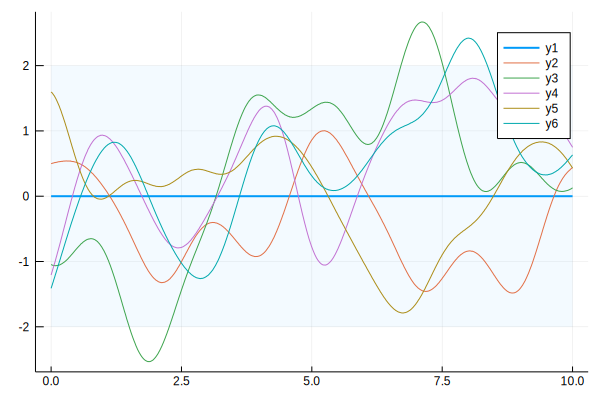

In [21]:
x_test = [x for x in 0:0.01:10]
mean, cov = prior_predict_f(gp, x_test)
samples = mwn_sample(mean, cov, 5)
plot(x_test, mean, width=2, ribbon=2sqrt.(diag(cov)), fillalpha=0.05)
plot!(x_test, samples)

## Posterior Distribution

In [22]:
# Generate Data from some GP
n = 50
X = rand(n) * last(x_test)
mean, cov = prior_predict_f(gp, X)
f = mwn_sample(mean, cov, 1)
y = f + randn(size(f)) * σ_n

50×1 Array{Float64,2}:
 -0.7514674802775638 
  2.8409526999426338 
 -0.8872836499627963 
  1.7731314740990722 
 -1.2395275176350795 
  1.355766543082405  
  2.9893622023204025 
 -1.1838131310456441 
  0.6743297535542312 
  0.6234719449469058 
 -1.1424660482286293 
 -0.8089803056005591 
 -0.7477135144696823 
  ⋮                  
  0.6748181268305349 
 -0.9914281738196967 
  1.5430109657886872 
 -0.08371573345637556
 -0.9501844764829377 
  1.917275013437662  
  2.6668746683996227 
  1.8192439108101421 
  0.7045822820293943 
  1.5251227396530211 
  2.3872982157872396 
  0.9963557428886602 

In [23]:
function posterior_predict_f(gp, x_test, X, y, σ_n, jitter=1e-6)
    k_mat(X₁, X₂) = [gp.k(x₁, x₂) for x₁ in X₁, x₂ in X₂]
    K = k_mat(X, X)
    K_s = k_mat(X, x_test)
    K_ss = k_mat(x_test, x_test)
    K_inv = inv(K + σ_n^2 * I + jitter*I)
    cov = K_ss - K_s' * K_inv * K_s
    mean = K_s' * K_inv * y
    return mean, cov
end

posterior_predict_f (generic function with 2 methods)

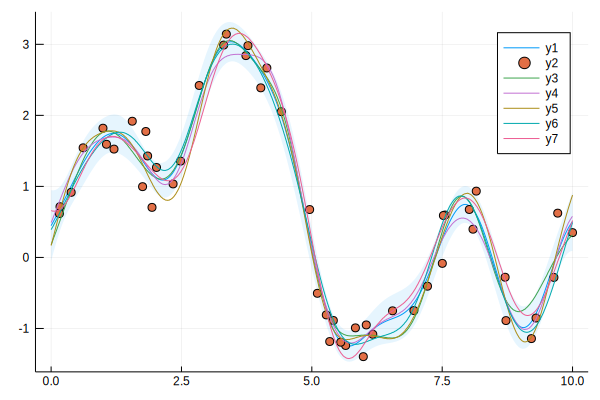

In [24]:
mean, cov = posterior_predict_f(gp, x_test, X, y, σ_n)

plot(x_test, mean, ribbon=2sqrt.(diag(cov)), fillalpha=0.1)
scatter!(X, y)

samples = mwn_sample(mean, cov, 5)
plot!(x_test, samples)